In [10]:
import pandas as pd
import time
import os
import re
import argparse
#Create dataset from the Refit dataset

DATA_DIRECTORY = 'Processed_Data_CSV/'
SAVE_PATH = 'microwave/'
AGG_MEAN = 522
AGG_STD = 814


params_appliance = {
    'kettle': {
        'windowlength': 599,
        'on_power_threshold': 2000,
        'max_on_power': 3998,
        'mean': 700,
        'std': 1000,
        's2s_length': 128,
        'houses': [2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 19, 20],
        'channels': [8, 9, 9, 8, 7, 9, 9, 7, 6, 9, 5, 9],
        'test_house': 2,
        'validation_house': 5,
        'test_on_train_house': 5,
    },
    'microwave': {
        'windowlength': 599,
        'on_power_threshold': 200,
        'max_on_power': 3969,
        'mean': 500,
        'std': 800,
        's2s_length': 128,
        'houses': [4, 10, 12, 17, 19],
        'channels': [8, 8, 3, 7, 4],
        'test_house': 4,
        'validation_house': 17,
        'test_on_train_house': 10,
    },
    'fridge': {
        'windowlength': 599,
        'on_power_threshold': 50,
        'max_on_power': 3323,
        'mean': 200,
        'std': 400,
        's2s_length': 512,
        'houses': [2, 5, 9, 12, 15],
        'channels': [1, 1, 1,  1, 1],
        'test_house': 15,
        'validation_house': 12,
        'test_on_train_house': 5,
    },
    'television': {
        'windowlength': 599,
        'on_power_threshold': 40,
        'max_on_power': 400,
        'mean': 150,
        'std': 100,
        's2s_length': 512,
        'houses': [1,3,4,8,9,10,21],
        'channels':[8,7,7,7,5,7,6],
        'test_house': 18,
        'validation_house': 7,
        'test_on_train_house': 8,
    },
  
}

class get_arguments:
    def __init__(self):
        self.data_dir = "microwave/"
        self.appliance_name = "microwave"
        self.aggregate_mean = 522
        self.aggregate_std = 822
        self.save_path = SAVE_PATH

args = get_arguments()



# def get_arguments():
#     parser = argparse.ArgumentParser(description='sequence to point learning \
#                                      example for NILM')
#     parser.add_argument('--data_dir', type=str, default=DATA_DIRECTORY,
#                           help='The directory containing the CLEAN REFIT data')
#     parser.add_argument('--appliance_name', type=str, default='kettle',
#                           help='which appliance you want to train: kettle,\
#                           microwave,fridge,television')
#     parser.add_argument('--aggregate_mean',type=int,default=AGG_MEAN,
#                         help='Mean value of aggregated reading (mains)')
#     parser.add_argument('--aggregate_std',type=int,default=AGG_STD,
#                         help='Std value of aggregated reading (mains)')
#     parser.add_argument('--save_path', type=str, default=SAVE_PATH,
#                           help='The directory to store the training data')
#     return parser.parse_args()

def load(path, building, appliance, channel):
    file_name = os.path.join(path, f'CLEAN_House{building}.csv')
    return pd.read_csv(
        file_name,
        header=0,
        names=['aggregate', appliance],
        usecols=[2, channel + 2],
        na_filter=False,
        parse_dates=True,
        infer_datetime_format=True,
        memory_map=True
    )

mains_data = {
    "mean": 522,
    "std":  814        
    }


In [ ]:
def main():
    start_time = time.time()        
    # test path
    # path = '../../../data/refit/CLEAN_REFIT_081116/'
    # save_path = 'refitdata/'
    
    args = get_arguments()
    
    appliance_name = args.appliance_name
    print(appliance_name)
    
    path = args.data_dir
    save_path = args.save_path
    if not os.path.exists(appliance_name):
        os.makedirs(appliance_name)
    save_path = appliance_name + '/'
    print(path)
    aggregate_mean = args.aggregate_mean#522
    aggregate_std = args.aggregate_std#814  
    
    total_length = 0
    print("Starting creating dataset...")
    # Looking for proper files
    for idx, filename in enumerate(os.listdir(path)):
        single_step_time = time.time()
    
        if filename == 'CLEAN_House' + str(params_appliance[appliance_name]['test_house']) + '.csv':
            print('File: ' + filename + ' test set')
            # Loading
            test = load(path,
                 params_appliance[appliance_name]['test_house'],
                 appliance_name,
                 params_appliance[appliance_name]['channels'][params_appliance[appliance_name]['houses']
                        .index(params_appliance[appliance_name]['test_house'])]
                 )
    
            # Normalization
            test['aggregate'] = (test['aggregate'] - aggregate_mean) / aggregate_std
            test[appliance_name] = \
                (test[appliance_name] - params_appliance[appliance_name]['mean']) / params_appliance[appliance_name]['std']
    
            # Save
            test.to_csv(save_path + appliance_name + '_test_' + 'H' + str(params_appliance[appliance_name]['test_house'])
                        + '.csv', index=False)
    
            print("Size of test set is {:.3f} M rows (House {:d})."
                  .format(test.shape[0] / 10 ** 6, params_appliance[appliance_name]['test_house']))
            del test
    
        elif filename == 'CLEAN_House' + str(params_appliance[appliance_name]['validation_house']) + '.csv':
            print('File: ' + filename + ' validation set')
            # Loading
            val = load(path,
                 params_appliance[appliance_name]['validation_house'],
                 appliance_name,
                 params_appliance[appliance_name]['channels']
                 [params_appliance[appliance_name]['houses']
                        .index(params_appliance[appliance_name]['validation_house'])]
                 )
    
            # Normalization
            val['aggregate'] = (val['aggregate'] - aggregate_mean) / aggregate_std
            val[appliance_name] = \
                (val[appliance_name] - params_appliance[appliance_name]['mean']) / params_appliance[appliance_name]['std']
    
            # Save
            val.to_csv(save_path + appliance_name + '_validation_' + 'H' + str(params_appliance[appliance_name]['validation_house'])
                       + '.csv', index=False)
    
            print("Size of validation set is {:.3f} M rows (House {:d})."
                  .format(val.shape[0] / 10 ** 6, params_appliance[appliance_name]['validation_house']))
            del val
    
        elif int(re.search(r'\d+', filename).group()) in params_appliance[appliance_name]['houses']:
            print('File: ' + filename)
            print('    House: ' + re.search(r'\d+', filename).group())
    
            # Loading
            try:
                csv = load(path,
                           int(re.search(r'\d+', filename).group()),
                           appliance_name,
                           params_appliance[appliance_name]['channels']
                           [params_appliance[appliance_name]['houses']
                                  .index(int(re.search(r'\d+', filename).group()))]
                           )
    
                # Normalization
                csv['aggregate'] = (csv['aggregate'] - aggregate_mean) / aggregate_std
                csv[appliance_name] = \
                    (csv[appliance_name] - params_appliance[appliance_name]['mean']) / params_appliance[appliance_name][
                        'std']
    
                rows, columns = csv.shape
                total_length += rows
    
                if filename == 'CLEAN_House' + str(params_appliance[appliance_name]['test_on_train_house']) + '.csv':
                    csv.to_csv(save_path + appliance_name + '_test_on_train_' + 'H' + str(
                        params_appliance[appliance_name]['test_on_train_house'])
                               + '.csv', index=False)
                    print("Size of test on train set is {:.3f} M rows (House {:d})."
                          .format(csv.shape[0] / 10 ** 6, params_appliance[appliance_name]['test_on_train_house']))
    
                # saving the whole merged file
                csv.to_csv(save_path + appliance_name + '_training_.csv', mode='a', index=False, header=False)
    
                del csv
    
            except:
                pass
    
            #print('    total_partial length: {}'.format(total_length / 10 ** 6))
    
    print("Size of training set is {:.3f} M rows.".format(total_length / 10 ** 6))
    print("\nNormalization parameters: ")
    print("Mean and standard deviation values USED for AGGREGATE are:")
    print("    Mean = {:d}, STD = {:d}".format(aggregate_mean, aggregate_std))
    print('Mean and standard deviation values USED for ' + appliance_name + ' are:')
    print("    Mean = {:d}, STD = {:d}"
          .format(params_appliance[appliance_name]['mean'], params_appliance[appliance_name]['std']))
    print("\nTraining, validation and test sets are  in: " + save_path)
    print("Total elapsed time: {:.2f} min.".format((time.time() - start_time) / 60))
    
if __name__ == '__main__':
    main()


AttributeError: 'FigureManagerBase' object has no attribute 'window'

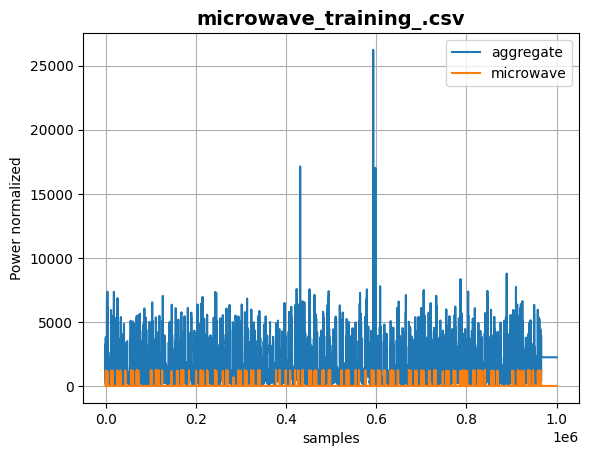

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd

appliance_name = 'microwave'

dataset = 'training'
#dataset = 'test'
#dataset = 'validation'
#dataset = 'train'

for filename in os.listdir( appliance_name):
        if dataset == 'train' and dataset.upper() in filename.upper() and 'TEST' in filename.upper():
            test_filename = filename
        elif dataset == 'training' and dataset.upper() in filename.upper():
            test_filename = filename
        elif dataset == 'test' and dataset.upper() in filename.upper() and 'train' not in filename.upper():
            test_filename = filename
        elif dataset == 'validation' and dataset.upper() in filename.upper():
            test_filename = filename

chunksize = 10 ** 6

for idx, chunk in enumerate(pd.read_csv( appliance_name + '/' + test_filename,
                                        # index_col=False,
                                        names=['aggregate', appliance_name],
                                        # usecols=[1, 2],
                                        # iterator=True,
                                        #skiprows=15 * 10 ** 6,
                                        chunksize=chunksize,
                                        header=0
                                        )):

    # de-normalization
    chunk['aggregate'] = chunk['aggregate'] * 822 + 522
    chunk[appliance_name] = chunk[appliance_name] * params_appliance[args.appliance_name]['std'] \
                      + params_appliance[args.appliance_name]['mean']


    fig = plt.figure(num='Figure {:}'.format(idx))
    ax1 = fig.add_subplot(111)

    ax1.plot(chunk['aggregate'])
    ax1.plot(chunk[appliance_name])

    ax1.grid()
    ax1.set_title('{:}'.format(test_filename), fontsize=14, fontweight='bold')
    ax1.set_ylabel('Power normalized')
    ax1.set_xlabel('samples')
    ax1.legend(['aggregate', appliance_name])

    mng = plt.get_current_fig_manager()
    mng.resize(*mng.windowlength.maxsize())
    plt.show(fig)

    del chunk


In [11]:
import numpy as np 
import pandas as pd 

# batch_size: the number of rows fed into the network at once.
# crop: the number of rows in the data set to be used in total.
# chunk_size: the number of lines to read from the file at once.

class TrainSlidingWindowGenerator():

    """Yields features and targets for training a ConvNet.

    Parameters:
    __file_name (string): The path where the training dataset is located.
    __batch_size (int): The size of each batch from the dataset to be processed.
    __chunk_size (int): The size of each chunk of data to be processed.
    __shuffle (bool): Whether the dataset should be shuffled before being returned.
    __offset (int):
    __crop (int): The number of rows of the dataset to return.
    __skip_rows (int): The number of rows of a dataset to skip before reading data.
    __ram_threshold (int): The maximum amount of RAM to utilise at a time.
    total_size (int): The number of rows read from the dataset.

    """

    def __init__(self, 
                file_name, 
                chunk_size, 
                offset,
                shuffle = True,
                batch_size=1000, 
                crop=100000, 
                skip_rows=0, 
                ram_threshold=5 * 10 ** 5):
        self.__file_name = file_name
        self.__batch_size = batch_size
        self.__chunk_size = 10 ** 8
        self.__shuffle = shuffle
        self.__offset = offset
        self.__crop = crop
        self.__skip_rows = skip_rows
        self.__ram_threshold = ram_threshold
        self.total_size = 0
        self.__total_num_samples = crop

    @property
    def total_num_samples(self):
        return self.__total_num_samples
    
    @total_num_samples.setter
    def total_num_samples(self, value):
        self.__total_num_samples = value

    def check_if_chunking(self):

        """Count the number of rows in the dataset and determine whether this is larger than the chunking 
        threshold or not. """

        # Loads the file and counts the number of rows it contains.
        print("Importing training file...")
        chunks = pd.read_csv(self.__file_name, 
                            header=0, 
                            nrows=self.__crop, 
                            skiprows=self.__skip_rows)
        print("Counting number of rows...")
        self.total_size = len(chunks)
        del chunks
        print("Done.")

        print("The dataset contains ", self.total_size, " rows")

        # Display a warning if there are too many rows to fit in the designated amount RAM.
        if (self.total_size > self.__ram_threshold):
            print("There is too much data to load into memory, so it will be loaded in chunks. Please note that this may result in decreased training times.")
    

    def load_dataset(self):

        """Yields pairs of features and targets that will be used directly by a neural network for training.

        Yields:
        input_data (numpy.array): A 1D array of size batch_size containing features of a single input. 
        output_data (numpy.array): A 1D array of size batch_size containing the target values corresponding to 
        each feature set.

        """

        if self.total_size == 0:
            self.check_if_chunking()

        # If the data can be loaded in one go, don't skip any rows.
        if (self.total_size <= self.__ram_threshold):

            # Returns an array of the content from the CSV file.
            data_array = np.array(pd.read_csv(self.__file_name, nrows=self.__crop, skiprows=self.__skip_rows, header=0))
            inputs = data_array[:, 0]
            outputs = data_array[:, 1]

            maximum_batch_size = inputs.size - 2 * self.__offset
            self.total_num_samples = maximum_batch_size
            if self.__batch_size < 0:
                self.__batch_size = maximum_batch_size

            indicies = np.arange(maximum_batch_size)
            if self.__shuffle:
                np.random.shuffle(indicies)

            while True:
                for start_index in range(0, maximum_batch_size, self.__batch_size):
                    splice = indicies[start_index : start_index + self.__batch_size]
                    input_data = np.array([inputs[index : index + 2 * self.__offset + 1] for index in splice])
                    output_data = outputs[splice + self.__offset].reshape(-1, 1)

                    yield input_data, output_data
                    
        # Skip rows where needed to allow data to be loaded properly when there is not enough memory.
        if (self.total_size >= self.__ram_threshold):
            number_of_chunks = np.arange(self.total_size / self.__chunk_size)
            if self.__shuffle:
                np.random.shuffle(number_of_chunks)

            # Yield the data in sections.
            for index in number_of_chunks:
                data_array = np.array(pd.read_csv(self.__file_name, skiprows=int(index) * self.__chunk_size, header=0, nrows=self.__crop))                   
                inputs = data_array[:, 0]
                outputs = data_array[:, 1]

                maximum_batch_size = inputs.size - 2 * self.__offset
                self.total_num_samples = maximum_batch_size
                if self.__batch_size < 0:
                    self.__batch_size = maximum_batch_size

                indicies = np.arange(maximum_batch_size)
                if self.__shuffle:
                    np.random.shuffle(indicies)

            while True:
                for start_index in range(0, maximum_batch_size, self.__batch_size):
                    splice = indicies[start_index : start_index + self.__batch_size]
                    input_data = np.array([inputs[index : index + 2 * self.__offset + 1] for index in splice])
                    output_data = outputs[splice + self.__offset].reshape(-1, 1)

                    yield input_data, output_data
                    
class TestSlidingWindowGenerator(object):

    """Yields features and targets for testing and validating a ConvNet.

    Parameters:
    __number_of_windows (int): The number of sliding windows to produce.
    __offset (int): The offset of the infered value from the sliding window.
    __inputs (numpy.ndarray): The available testing / validation features.
    __targets (numpy.ndarray): The target values corresponding to __inputs.
    __total_size (int): The total number of inputs.

    """

    def __init__(self, number_of_windows, inputs, targets, offset): # `targets`, was removed
        self.__number_of_windows = number_of_windows
        self.__offset = offset
        self.__inputs = inputs
        self.__targets = targets
        self.total_size = len(inputs)

    def load_dataset(self):

        """Yields features and targets for testing and validating a ConvNet.

        Yields:
        input_data (numpy.array): An array of features to test / validate the network with.

        """

        self.__inputs = self.__inputs.flatten()
        max_number_of_windows = self.__inputs.size - 2 * self.__offset

        if self.__number_of_windows < 0:
            self.__number_of_windows = max_number_of_windows

        indicies = np.arange(max_number_of_windows, dtype=int)
        #changes made here
        """
        for start_index in range(0, max_number_of_windows, self.__number_of_windows):
            splice = indicies[start_index : start_index + self.__number_of_windows]
            input_data = np.array([self.__inputs[index : index + 2 * self.__offset + 1] for index in splice])
            target_data = self.__targets[splice + self.__offset].reshape(-1, 1)
            yield input_data, target_data"""
        splice = indicies[:self.__number_of_windows]
        input_data = np.array([
            self.__inputs[index: index + 2 * self.__offset + 1]
            for index in splice
        ])
        target_data = self.__targets[splice + self.__offset].reshape(-1, 1)#removed changed target from  #this was commented

        return input_data, target_data 
    

    def get_test_input_data(self):
        """Returns the full sliding window input data, without targets (for inference)."""
        self.__inputs = self.__inputs.flatten()
        max_number_of_windows = self.__inputs.size - 2 * self.__offset

        if self.__number_of_windows < 0:
            self.__number_of_windows = max_number_of_windows

        indices = np.arange(max_number_of_windows, dtype=int)
        splice = indices[:self.__number_of_windows]

        input_data = np.array([
            self.__inputs[index : index + 2 * self.__offset + 1]
            for index in splice
        ])

        return input_data



    #new function added to predict dataset
    def predict_dataset(self):
        self.__inputs = self.__inputs.flatten()
        max_number_of_windows = self.__inputs.size - 2 * self.__offset

        if self.__number_of_windows < 0:
            self.__number_of_windows = max_number_of_windows

        indices = np.arange(max_number_of_windows, dtype=int)
        for start_index in range(0, max_number_of_windows, self.__number_of_windows):
            splice = indices[start_index : start_index + self.__number_of_windows]
            input_data = np.array([
                self.__inputs[index : index + 2 * self.__offset + 1]
                for index in splice
            ])
            yield input_data  # ⬅️ ONLY input, not (input, target)


In [12]:
import tensorflow as tf 
import os

def create_model(input_window_length) -> tf.keras.Model:
    input_layer = tf.keras.layers.Input(shape=(input_window_length,))
    x = tf.keras.layers.Reshape((1, input_window_length, 1))(input_layer)

    x = tf.keras.layers.Conv2D(30, (10, 1), padding="same", activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Conv2D(30, (8, 1), padding="same", activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Conv2D(40, (6, 1), padding="same", activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Conv2D(50, (5, 1), padding="same", activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Conv2D(50, (5, 1), padding="same", activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    output_layer = tf.keras.layers.Dense(1, activation="linear")(x)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    return model




def save_model(model, network_type, algorithm, appliance, save_model_dir):

    """ Saves a model to a specified location. Models are named using a combination of their 
    target appliance, architecture, and pruning algorithm.

    Parameters:
    model (tensorflow.keras.Model): The Keras model to save.
    network_type (string): The architecture of the model ('', 'reduced', 'dropout', or 'reduced_dropout').
    algorithm (string): The pruning algorithm applied to the model.
    appliance (string): The appliance the model was trained with.

    """
    
    #model_path = "saved_models/" + appliance + "_" + algorithm + "_" + network_type + "_model.h5"
    model_path = save_model_dir

    if not os.path.exists (model_path):
        open((model_path), 'a').close()

    model.save(model_path)

def load_model(model, network_type, algorithm, appliance, saved_model_dir):

    """ Loads a model from a specified location.

    Parameters:
    model (tensorflow.keras.Model): The Keas model to which the loaded weights will be applied to.
    network_type (string): The architecture of the model ('', 'reduced', 'dropout', or 'reduced_dropout').
    algorithm (string): The pruning algorithm applied to the model.
    appliance (string): The appliance the model was trained with.

    """

    #model_name = "saved_models/" + appliance + "_" + algorithm + "_" + network_type + "_model.h5"
    model_name = saved_model_dir
    print("PATH NAME: ", model_name)

    model = tf.keras.models.load_model(model_name)
    num_of_weights = model.count_params()
    print("Loaded model with ", str(num_of_weights), " weights")
    return model

In [3]:
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt

#tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
class Trainer():

    """ Used to train a seq2point model with or without pruning applied Supports 
    various alternative architectures. 
    
    Parameters:
    __appliance (string): The target appliance.
    __network_type (string): The architecture of the model.
    __batch_size (int): The number of rows per testing batch.
    __window_size (int): The size of eaech sliding window
    __window_offset (int): The offset of the inferred value from the sliding window.
    __max_chunk_size (int): The largest possible number of row per chunk.
    __validation_frequency (int): The number of epochs between model validation.
    __training_directory (string): The directory of the model's training file.
    __validation_directory (string): The directory of the model's validation file.
    __training_chunker (TrainSlidingWindowGenerator): A sliding window provider 
    that returns feature / target pairs. For training use only.
    __validation_chunker (TrainSlidingWindowGenerator): A sliding window provider 
    that returns feature / target pairs. For validation use only.
    
    """

    def __init__(self, appliance, batch_size, crop, network_type, 
                 training_directory, validation_directory, save_model_dir,
                 epochs=10, input_window_length=599, validation_frequency = 1,
                 patience=3, min_delta=1e-6, verbose=1):
        self.__appliance = appliance
        self.__algorithm = network_type
        self.__network_type = network_type
        self.__crop = crop
        self.__batch_size = batch_size
        self.__epochs = epochs
        self.__patience = patience
        self.__min_delta = min_delta
        self.__verbose = verbose
        self.__loss = "mse"
        self.__metrics = ["mse", "msle", "mae"]
        self.__learning_rate = 0.0003
        self.__beta_1=0.9
        self.__beta_2=0.999
        self.__save_model_dir = save_model_dir

        self.__input_window_length = input_window_length
        self.__window_size = 2+self.__input_window_length
        self.__window_offset = int((0.5 * self.__window_size) - 1)
        self.__max_chunk_size = 5 * 10 ** 2
        self.__validation_frequency = validation_frequency
        self.__ram_threshold=5*10**5
        self.__skip_rows_train=10000000
        self.__validation_steps=100
        self.__skip_rows_val = 0

        # Directories of the training and validation files. Always has the structure 
        # ./dataset_management/refit/{appliance_name}/{appliance_name}_training_.csv for training or 
        # ./dataset_management/refit/{appliance_name}/{appliance_name}_validation_.csv
        self.__training_directory = training_directory
        self.__validation_directory = validation_directory

        self.__training_chunker = TrainSlidingWindowGenerator(file_name=self.__training_directory, 
                                        chunk_size=self.__max_chunk_size, 
                                        batch_size=self.__batch_size, 
                                        crop=self.__crop, shuffle=True,
                                        skip_rows=self.__skip_rows_train, 
                                        offset=self.__window_offset, 
                                        ram_threshold=self.__ram_threshold)
        self.__validation_chunker = TrainSlidingWindowGenerator(file_name=self.__validation_directory, 
                                            chunk_size=self.__max_chunk_size, 
                                            batch_size=self.__batch_size, 
                                            crop=self.__crop, 
                                            shuffle=True,
                                            skip_rows=self.__skip_rows_val, 
                                            offset=self.__window_offset, 
                                            ram_threshold=self.__ram_threshold)

    def train_model(self):

        """ Trains an energy disaggregation model using a user-selected pruning algorithm (default is no pruning). 
        Plots and saves the resulting model. """

        # Calculate the optimum steps per epoch.
        # self.__training_chunker.check_if_chunking()
        #steps_per_training_epoch = np.round(int(self.__training_chunker.total_size / self.__batch_size), decimals=0)
        steps_per_training_epoch = np.round(int(self.__training_chunker.total_num_samples / self.__batch_size), decimals=0)
        
        model = create_model(self.__input_window_length)

        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.__learning_rate, beta_1=self.__beta_1, beta_2=self.__beta_2), loss=self.__loss, metrics=self.__metrics) 
        #early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=self.__min_delta, patience=self.__patience, verbose=self.__verbose, mode="auto")

        ## can use checkpoint ###############################################
        #checkpoint_filepath = "checkpoint/housedata/refit/"+ self.__appliance + "/"
        #model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
         #    filepath = checkpoint_filepath,
          #   monitor='val_loss',
           #  verbose=0,
            # save_best_only=True,
            # save_weights_only=False,
         #    mode='auto',
          #   save_freq='epoch')        
        #callbacks=[early_stopping, model_checkpoint_callback]
        ###################################################################
        lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
            monitor = 'val_loss', factor = 0.5, patience = 2, verbose = 1, min_lr=1e-6
        )

        callbacks=[lr_schedule]
        self.__loss = tf.keras.losses.Huber()
        
        training_history = self.default_train(model, callbacks, steps_per_training_epoch)

        training_history.history["val_loss"] = np.repeat(training_history.history["val_loss"], self.__validation_frequency)

        model.summary()
        save_model(model, self.__network_type, self.__algorithm, 
                   self.__appliance, self.__save_model_dir)

        self.plot_training_results(training_history)

    def default_train(self, model, callbacks, steps_per_training_epoch):

        """ The default training method the neural network will use. No pruning occurs.

        Parameters:
        model (tensorflow.keras.Model): The seq2point model being trained.
        early_stopping (tensorflow.keras.callbacks.EarlyStopping): An early stopping callback to 
        prevent overfitting.
        steps_per_training_epoch (int): The number of training steps to occur per epoch.

        Returns:
        training_history (numpy.ndarray): The error metrics and loss values that were calculated 
        at the end of each training epoch.

        """
        # ########### this is retired ##############################
        # training_history = model.fit_generator(self.__training_chunker.load_dataset(),
        #     steps_per_epoch=steps_per_training_epoch,
        #     epochs=1,
        #     verbose=1,
        #     validation_data = self.__validation_chunker.load_dataset(),
        #     validation_steps=100,
        #     validation_freq=self.__validation_frequency,
        #     callbacks=[early_stopping])
        ############################################################

        training_history = model.fit(self.__training_chunker.load_dataset(),                            
                                      steps_per_epoch=steps_per_training_epoch,
                                      epochs = self.__epochs,
                                      verbose = self.__verbose,
                                      callbacks=callbacks,
                                      validation_data = self.__validation_chunker.load_dataset(),
                                      validation_freq=self.__validation_frequency,
                                      validation_steps=self.__validation_steps)

        return training_history

    def plot_training_results(self, training_history):

        """ Plots and saves a graph of training loss against epoch.

        Parameters:
        training_history (numpy.ndarray): A timeseries of loss against epoch count.

        """

        plt.plot(training_history.history["loss"], label="MSE (Training Loss)")
        plt.plot(training_history.history["val_loss"], label="MSE (Validation Loss)")
        plt.plot(training_history.history["mae"], label="MAE (Training Loss)")
        plt.plot(training_history.history["val_mae"], label="MAE (Validation Loss)")
        plt.plot(training_history.history["msle"], label="MSLE (Training Loss)")
        plt.plot(training_history.history["val_msle"], label="MSLE (Validation Loss)")
        plt.title('Training History')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend()

        #file_name = "./" + self.__appliance + "/saved_models/" + self.__appliance + "_" + self.__pruning_algorithm + "_" + self.__network_type + "_training_results.png"
        #plt.savefig(fname=file_name)

In [ ]:
import os
import logging
import numpy as np 
import keras
import pandas as pd
import tensorflow as tf 
import time
import matplotlib.pyplot as plt

class Tester():

    """ Used to test and evaluate a pre-trained seq2point model with or without pruning applied. 
    
    Parameters:
    __appliance (string): The target appliance.
    __algorithm (string): The (pruning) algorithm the model was trained with.
    __network_type (string): The architecture of the model.
    __crop (int): The maximum number of rows of data to evaluate the model with.
    __batch_size (int): The number of rows per testing batch.
    __window_size (int): The size of each sliding window
    __window_offset (int): The offset of the inferred value from the sliding window.
    __test_directory (string): The directory of the test file for the model.
    
    """

    def __init__(self, appliance, algorithm, crop, batch_size, network_type,
                 test_directory, saved_model_dir, log_file_dir,
                 input_window_length):
        self.__appliance = appliance
        self.__algorithm = algorithm
        self.__network_type = network_type

        self.__crop = crop
        self.__batch_size = batch_size
        self._input_window_length = input_window_length
        self.__window_size = self._input_window_length + 2
        self.__window_offset = int(0.5 * self.__window_size - 1)
        self.__number_of_windows = 100

        self.__test_directory = test_directory
        self.__saved_model_dir = saved_model_dir

        self.__log_file = log_file_dir
        logging.basicConfig(filename=self.__log_file,level=logging.INFO)


    
    def test_model(self):

        # Tests a fully-trained model using a sliding window generator as an input. Measures inference time, gathers, and 
        #plots evaluationg metrics. 

        test_input, test_target = self.load_dataset(self.__test_directory)
        #below 2 lines were commented
        model = create_model(self._input_window_length)
        model = load_model(model, self.__network_type, self.__algorithm, 
                           self.__appliance, self.__saved_model_dir)


        #change made
        #model = load_model(self.__saved_model_dir)
        #model = tf.keras.models.load_model(self.__saved_model_dir)



        test_generator = TestSlidingWindowGenerator(number_of_windows=self.__number_of_windows, inputs=test_input, targets=test_target, offset=self.__window_offset) #targets=test_target, was part

        # Calculate the optimum steps per epoch.
        steps_per_test_epoch = np.round(int(test_generator.total_size / self.__batch_size), decimals=0)

        # Test the model.
        start_time = time.time()
        #changes made here
        testing_history = model.predict(x=test_generator.get_test_input_data(), steps=steps_per_test_epoch,  verbose=2) #.load_dataset was changed to get_test_input_data

        end_time = time.time()
        test_time = end_time - start_time

        evaluation_metrics = model.evaluate(x=test_generator.get_test_input_data(), steps=steps_per_test_epoch)

        self.log_results(model, test_time, evaluation_metrics)
        # You must provide mains_data as a dictionary with "mean" and "std" keys
        self.plot_results(testing_history, test_input, test_target, mains_data)
    


    def load_dataset(self, directory):
        """Loads the testing dataset from the location specified by file_name.

        Parameters:
        directory (string): The location at which the dataset is stored, concatenated with the file name.

        Returns:
        test_input (numpy.array): The first n (crop) features of the test dataset.
        test_target (numpy.array): The first n (crop) targets of the test dataset.

        """

        data_frame = pd.read_csv(directory, nrows=self.__crop, skiprows=0, header=0)
        test_input = np.round(np.array(data_frame.iloc[:, 0], float), 6)
        test_target = np.round(np.array(data_frame.iloc[self.__window_offset: -self.__window_offset, 1], float), 6)
        
        del data_frame
        return test_input, test_target

    def log_results(self, model, test_time, evaluation_metrics):

        """Logs the inference time, MAE and MSE of an evaluated model.

        Parameters:
        model (tf.keras.Model): The evaluated model.
        test_time (float): The time taken by the model to infer all required values.
        evaluation metrics (list): The MSE, MAE, and various compression ratios of the model.

        """

        inference_log = "Inference Time: " + str(test_time)
        logging.info(inference_log)

        #changes made here
        #metric_string = "MSE: ", str(evaluation_metrics[0]), " MAE: ", str(evaluation_metrics[3])
        metric_string = f"MSE: {evaluation_metrics[0]} MAE: {evaluation_metrics[1]}"
        logging.info(metric_string)

        self.count_pruned_weights(model)  

    def count_pruned_weights(self, model):

        """ Counts the total number of weights, pruned weights, and weights in convolutional 
        layers. Calculates the sparsity ratio of different layer types and logs these values.

        Parameters:
        model (tf.keras.Model): The evaluated model.

        """
        num_total_zeros = 0
        num_dense_zeros = 0
        num_dense_weights = 0
        num_conv_zeros = 0
        num_conv_weights = 0
        for layer in model.layers:
             weights = layer.get_weights()
             if weights:
                layer_weights = weights[0].flatten()

                if "conv" in layer.name:
                    num_conv_weights += np.size(layer_weights)
                    num_conv_zeros += np.count_nonzero(layer_weights==0)

                    num_total_zeros += np.size(layer_weights)
                else:
                    num_dense_weights += np.size(layer_weights)
                    num_dense_zeros += np.count_nonzero(layer_weights==0)

        conv_zeros_string = "CONV. ZEROS: " + str(num_conv_zeros)
        conv_weights_string = "CONV. WEIGHTS: " + str(num_conv_weights)
        conv_sparsity_ratio = "CONV. RATIO: " + str(num_conv_zeros / num_conv_weights)

        dense_weights_string = "DENSE WEIGHTS: " + str(num_dense_weights)
        dense_zeros_string = "DENSE ZEROS: " + str(num_dense_zeros)
        dense_sparsity_ratio = "DENSE RATIO: " + str(num_dense_zeros / num_dense_weights)

        total_zeros_string = "TOTAL ZEROS: " + str(num_total_zeros)
        total_weights_string = "TOTAL WEIGHTS: " + str(model.count_params())
        total_sparsity_ratio = "TOTAL RATIO: " + str(num_total_zeros / model.count_params())

        print("LOGGING PATH: ", self.__log_file)

        logging.info(conv_zeros_string)
        logging.info(conv_weights_string)
        logging.info(conv_sparsity_ratio)
        logging.info("")
        logging.info(dense_zeros_string)
        logging.info(dense_weights_string)
        logging.info(dense_sparsity_ratio)
        logging.info("")
        logging.info(total_zeros_string)
        logging.info(total_weights_string)
        logging.info(total_sparsity_ratio)


    def get_accuracy(target, prediction, threshold):

    tp = get_TP(target, prediction, threshold)
    tn = get_TN(target, prediction, threshold)

    accuracy = (tp + tn) / target.size

    return accuracy


    def plot_results(self, testing_history, test_input, test_target, mains_data):

        """ Generates and saves a plot of the testing history of the model against the (actual) 
        aggregate energy values and the true appliance values.

        Parameters:
        testing_history (numpy.ndarray): The series of values inferred by the model.
        test_input (numpy.ndarray): The aggregate energy data.
        test_target (numpy.ndarray): The true energy values of the appliance.
        mains_data (dict): Dictionary containing "mean" and "std" for the aggregate mains data.

        """

       # testing_history = ((testing_history * params_appliance[self.__appliance]["std"]) + params_appliance[self.__appliance]["mean"])
        #test_target = ((test_target * params_appliance[self.__appliance]["std"]) + params_appliance[self.__appliance]["mean"])
       # test_agg = (test_input.flatten() * mains_data["std"]) + mains_data["mean"]
        #test_agg = test_agg[:testing_history.size]

        # Can't have negative energy readings - set any results below 0 to 0.
      #  test_target[test_target < 0] = 0
       ##test_input[test_input < 0] = 0

        # Plot testing outcomes against ground truth.
        plt.figure(1)
        #plt.plot(test_agg[self.__window_offset: -self.__window_offset], label="Aggregate")
        #plt.plot(test_target, label="Ground Truth")
        plt.plot(testing_history, label="Predicted")
        plt.title(self.__appliance + " " + self.__network_type + "(" + self.__algorithm + ")")
        plt.ylabel("Power Value (Watts)")
        plt.xlabel("Testing Window")
        plt.legend()

        #file_path = "./" + self.__appliance + "/saved_models/" + self.__appliance + "_" + self.__algorithm + "_" + self.__network_type + "_test_figure.png"
        #plt.savefig(fname=file_path)

        plt.show()
        plt.show()

Importing training file...
Counting number of rows...
Done.
The dataset contains  599  rows
Epoch 1/20
1/1 [==============================] - ETA: 0s - loss: 0.0886 - mse: 0.0886 - msle: 0.0000e+00 - mae: 0.2976Importing training file...
Counting number of rows...
Done.
The dataset contains  599  rows
1/1 [==============================] - 32s 32s/step - loss: 0.0886 - mse: 0.0886 - msle: 0.0000e+00 - mae: 0.2976 - val_loss: 0.3502 - val_mse: 0.3502 - val_msle: 0.0000e+00 - val_mae: 0.5918 - lr: 3.0000e-04
Epoch 2/20
1/1 [==============================] - 1s 1s/step - loss: 3885.5195 - mse: 3885.5195 - msle: 0.0000e+00 - mae: 62.3339 - val_loss: 0.3594 - val_mse: 0.3594 - val_msle: 0.0000e+00 - val_mae: 0.5995 - lr: 3.0000e-04
Epoch 3/20
1/1 [==============================] - ETA: 0s - loss: 242.6709 - mse: 242.6709 - msle: 0.0000e+00 - mae: 15.5779
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
1/1 [==============================] - 1s 832ms/step - loss: 2

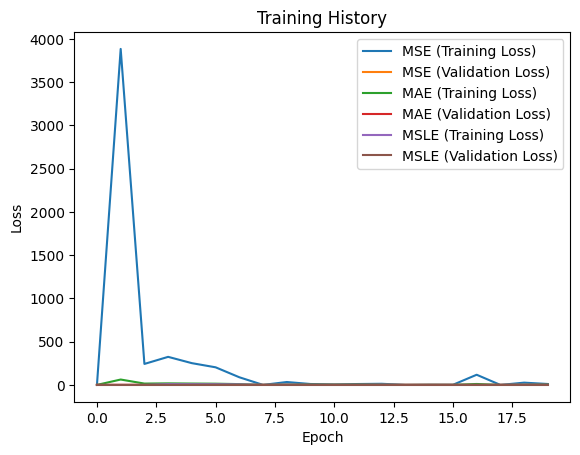

In [11]:
# Set parameters
appliance = "microwave"
network_type = "seq2point"
crop = 599
batch_size = 512
training_directory = "microwave/microwave_training_.csv"
validation_directory = "microwave/microwave_validation_H17.csv"
save_model_dir="saved_models/microwave_seq2point_model.h5"
epochs = 20

# Create Trainer instance
trainer = Trainer(
    appliance=appliance,
    batch_size=batch_size,
    crop=crop,
    network_type=network_type,
    training_directory=training_directory,
    validation_directory=validation_directory,
    save_model_dir=save_model_dir,
    epochs=epochs,
    input_window_length=crop
)

# Train the model
trainer.train_model()


In [ ]:
def remove_space(string):
    return string.replace(" ","")

In [14]:
config = {
    "appliance_name": "microwave",
    "batch_size": 1000,
    "crop": 10000,
    "algorithm": "seq2point",
    "network_type": "default",  # could be: default, dropout, reduced, reduced_dropout
    "input_window_length": 599,
    "training_directory": "microwave/microwave_training_.csv",
    "validation_directory": "microwave/microwave_validation_H9.csv",
    "test_directory": "microwave/microwave_test_H10.csv",
    "save_model_dir": "saved_models/microwave_seq2point_model.h5",
    "log_file_dir": "saved_models/microwave_seq2point_default.log",
    "epochs": 10
}

tester = Tester(
    appliance="kettle",
    algorithm="seq2point",
    crop=10000,
    batch_size=1000,
    network_type="default",
    test_directory="kettle/kettle_test_H2.csv",
    saved_model_dir="transfer_learned_models/cnn_s2p_kettle_pointnet_model_weights.h5",
    log_file_dir="saved_models/kettle_seq2point_default.log",
    input_window_length=599
)


tester.test_model()

#if it does not work, delete test_generator and replace with testslidingwindowgenerator

PATH NAME:  transfer_learned_models/cnn_s2p_kettle_pointnet_model_weights.h5


ValueError: No model config found in the file at <tensorflow.python.platform.gfile.GFile object at 0x000002C1FC3A11E0>.

In [9]:
# Configuration - define these at the top of the notebook
config = {
    "appliance_name": "kettle",
    "batch_size": 1000,
    "crop": 10000,
    "algorithm": "seq2point",
    "network_type": "default",  # could be: default, dropout, reduced, reduced_dropout
    "input_window_length": 599,
    "training_directory": "kettle/kettle_training_.csv",
    "validation_directory": "kettle/kettle_validation_H5.csv",
    "test_directory": "kettle/kettle_test_H2.csv",
    "save_model_dir": "saved_models/kettle_best_model.h5",
    "log_file_dir": "saved_models/kettle_seq2point_default.log",
    "epochs": 10
}


In [ ]:
# Run the Tester using the config dictionary defined earlier in the notebook

tester = Tester(
    appliance=config["appliance_name"],
    algorithm=config["algorithm"],
    crop=config["crop"],
    batch_size=config["batch_size"],
    network_type=config["network_type"],
    test_directory=config["test_directory"],
    saved_model_dir=config["save_model_dir"],
    log_file_dir=config["log_file_dir"],
    input_window_length=config["input_window_length"]
)

tester.test_model()

In [10]:
# Get test input and target using the tester's load_dataset method
test_input, test_target = tester.load_dataset(config["test_directory"])

# Prepare the sliding window generator for inference
window_offset = int(0.5 * (config["input_window_length"] + 2) - 1)
number_of_windows = 100  # or set as needed

test_gen = TestSlidingWindowGenerator(
	number_of_windows=number_of_windows,
	inputs=test_input,
	targets=test_target,
	offset=window_offset
)

# Load the trained model
model = create_model(config["input_window_length"])
model = load_model(
	model,
	config["network_type"],
	config["algorithm"],
	config["appliance_name"],
	config["save_model_dir"]
)

# Get predictions
test_inputs_for_pred = test_gen.get_test_input_data()
predictions = model.predict(test_inputs_for_pred)

print("Sample predictions:", predictions[:10].flatten())
print("Sample targets:", test_target[:10].flatten())




PATH NAME:  saved_models/kettle_best_model.h5
Loaded model with  30709049  weights
4/4 [==============================] - 3s 117ms/step
Sample predictions: [-0.08369238 -0.08367307 -0.0836724  -0.08366593 -0.0836658  -0.08365405
 -0.08358364 -0.0836004  -0.0835894  -0.08356615]
Sample targets: [-0.7 -0.7 -0.7 -0.7 -0.7 -0.7 -0.7 -0.7 -0.7 -0.7]


In [5]:
import h5py

with h5py.File('transfer_learned_models/cnn_s2p_kettle_pointnet_model_weights.h5', 'r') as f:
    print(list(f.keys()))


['conv2d', 'conv2d_1', 'conv2d_2', 'conv2d_3', 'conv2d_4', 'dense', 'flatten', 'input_1', 'output', 'reshape', 'top_level_model_weights']
